In [24]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

In [2]:
import nltk
from nltk.corpus import stopwords
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [3]:
import re
import string

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
# 1. Get the dataset from Hugging Face
dataset_name = "cnamuangtoun/resume-job-description-fit"
try:
    dataset = load_dataset(dataset_name)
    df = dataset['train'].to_pandas()
    print(f"Dataset '{dataset_name}' loaded successfully. Shape: {df.shape}")
    print("Column names in the DataFrame:")
    print(df.columns)
    # We need to identify the correct column names for text and labels
    TEXT_COLUMN = None  # We will update this based on the output
    LABEL_COLUMN = None # We will update this based on the output
except Exception as e:
    print(f"Error loading dataset '{dataset_name}': {e}")
    exit()

Dataset 'cnamuangtoun/resume-job-description-fit' loaded successfully. Shape: (6241, 3)
Column names in the DataFrame:
Index(['resume_text', 'job_description_text', 'label'], dtype='object')


In [7]:
# 2. Preprocessing
TEXT_COLUMN_RESUME = 'resume_text'
TEXT_COLUMN_JOB = 'job_description_text'
LABEL_COLUMN = 'label'

stop_words = set(stopwords.words('english'))
custom_stopwords = ['e.g.', 'i.e.', 'etc.', 'the', 'and', 'a', 'an', 'in', 'of', 'to'] # Add more if needed
stop_words.update(custom_stopwords)

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove numbers (keeping those with % $ or year format)
        text = re.sub(r'(?<!\d)(?<![\$\%])\b\d+\b', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove stopwords
        text_tokens = text.split()
        filtered_tokens = [w for w in text_tokens if not w in stop_words]
        return " ".join(filtered_tokens)
    return ""

print("Applying preprocessing...")
df['processed_resume'] = df[TEXT_COLUMN_RESUME].apply(preprocess_text)
df['processed_job_description'] = df[TEXT_COLUMN_JOB].apply(preprocess_text)
# Combine processed resume and job description for the model
df['combined_text'] = df['processed_resume'] + ' ' + df['processed_job_description']
df = df[df['combined_text'].str.len() > 0] # Remove rows with empty combined text
print("Preprocessing complete.")

Applying preprocessing...
Preprocessing complete.


In [8]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Tokenize the texts
df['resume_tokens'] = df['processed_resume'].apply(word_tokenize)
df['job_tokens'] = df['processed_job_description'].apply(word_tokenize)

# Combine for training Word2Vec
sentences = df['resume_tokens'].tolist() + df['job_tokens'].tolist()

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average word vectors
def average_word_vectors(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

# Create average vectors for resumes and job descriptions
df['resume_vec'] = df['resume_tokens'].apply(lambda x: average_word_vectors(x, w2v_model, 100))
df['job_vec'] = df['job_tokens'].apply(lambda x: average_word_vectors(x, w2v_model, 100))

# Prepare training/testing sets
from sklearn.model_selection import train_test_split
X_resume = np.stack(df['resume_vec'].values)
X_job = np.stack(df['job_vec'].values)
y = df[LABEL_COLUMN]

X_resume_train, X_resume_test, X_job_train, X_job_test, y_train, y_test = train_test_split(
    X_resume, X_job, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Calculate Cosine Similarity
print("Calculating cosine similarity...")

def calculate_word2vec_similarity(resume_word2vec, job_word2vec):
    return cosine_similarity(resume_word2vec.reshape(1, -1), job_word2vec.reshape(1, -1))[0][0]

train_similarity = [
    calculate_word2vec_similarity(X_resume_train[i], X_job_train[i])
    for i in range(X_resume_train.shape[0])
]

test_similarity = [
    calculate_word2vec_similarity(X_resume_test[i], X_job_test[i])
    for i in range(X_resume_test.shape[0])
]

print("Cosine similarity calculated.")

Calculating cosine similarity...
Cosine similarity calculated.


In [11]:
# Prepare data for the model
X_train_word2vec = pd.DataFrame(X_resume_train, columns=[f'word2vec_resume_{i}' for i in range(X_resume_train.shape[1])])
X_job_word2vec = pd.DataFrame(X_job_train, columns=[f'word2vec_job_{i}' for i in range(X_job_train.shape[1])])
X_train_model = pd.concat([X_train_word2vec, X_job_word2vec], axis=1)
X_train_model['similarity'] = train_similarity
X_train_model.columns = X_train_model.columns.astype(str)  # Convert all column names to strings

X_test_word2vec = pd.DataFrame(X_resume_test, columns=[f'word2vec_resume_{i}' for i in range(X_resume_test.shape[1])])
X_job_test_word2vec = pd.DataFrame(X_job_test, columns=[f'word2vec_job_{i}' for i in range(X_job_test.shape[1])])
X_test_model = pd.concat([X_test_word2vec, X_job_test_word2vec], axis=1)
X_test_model['similarity'] = test_similarity
X_test_model.columns = X_test_model.columns.astype(str)    # Convert all column names to strings

In [17]:
# Initialize and train the models
gnb = GaussianNB()
gnb.fit(X_train_model, y_train)
gnb_predictions_combined = gnb.predict(X_test_model)


# Evaluate the model with combined features
print("\nGaussian Naive Bayes with word2vec embedding  and Cosine Similarity:")
print(classification_report(y_test, gnb_predictions_combined))
print("Accuracy:", accuracy_score(y_test, gnb_predictions_combined))


Gaussian Naive Bayes with word2vec embedding  and Cosine Similarity:
               precision    recall  f1-score   support

     Good Fit       0.37      0.52      0.43       309
       No Fit       0.67      0.52      0.58       629
Potential Fit       0.36      0.39      0.37       311

     accuracy                           0.49      1249
    macro avg       0.47      0.47      0.46      1249
 weighted avg       0.52      0.49      0.49      1249

Accuracy: 0.4851881505204163


In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_model, y_train)
rf_predictions = rf.predict(X_test_model)

print("\nRandom Forest with word2vec embedding and Cosine Similarity:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest with word2vec embedding and Cosine Similarity:
               precision    recall  f1-score   support

     Good Fit       0.67      0.80      0.73       309
       No Fit       0.76      0.80      0.78       629
Potential Fit       0.74      0.52      0.61       311

     accuracy                           0.73      1249
    macro avg       0.72      0.71      0.71      1249
 weighted avg       0.73      0.73      0.73      1249

Accuracy: 0.7317854283426741


In [19]:
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
y_train_encoded = y_train.map(label_mapping)

y_test_encoded = y_test.map(label_mapping)

In [20]:
# Initialize and train the XGBoost model with combined features
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_model, y_train_encoded)  # Use the numerically encoded y_train
xgb_predictions = xgb_model.predict(X_test_model)

# Evaluate the model with combined features
print("\nXGBoost with word2vec embedding and Cosine Similarity:")
print(classification_report(y_test_encoded, xgb_predictions))
print("Accuracy:", accuracy_score(y_test_encoded, xgb_predictions))


XGBoost with word2vec embedding and Cosine Similarity:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       629
           1       0.74      0.61      0.67       311
           2       0.69      0.82      0.75       309

    accuracy                           0.75      1249
   macro avg       0.74      0.74      0.74      1249
weighted avg       0.76      0.75      0.75      1249

Accuracy: 0.7542033626901521


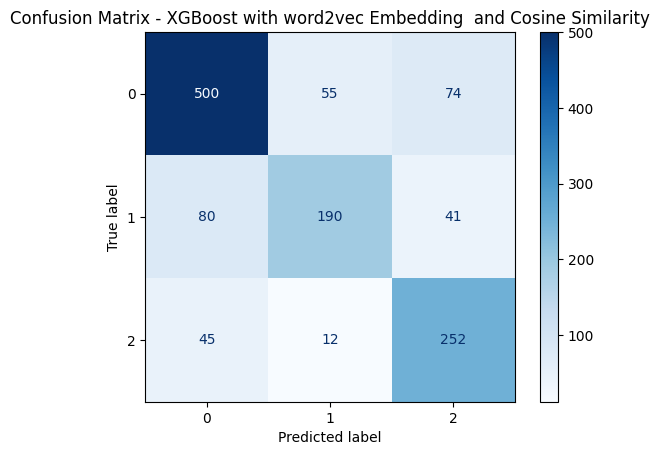

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, xgb_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost with word2vec Embedding  and Cosine Similarity")
plt.show()


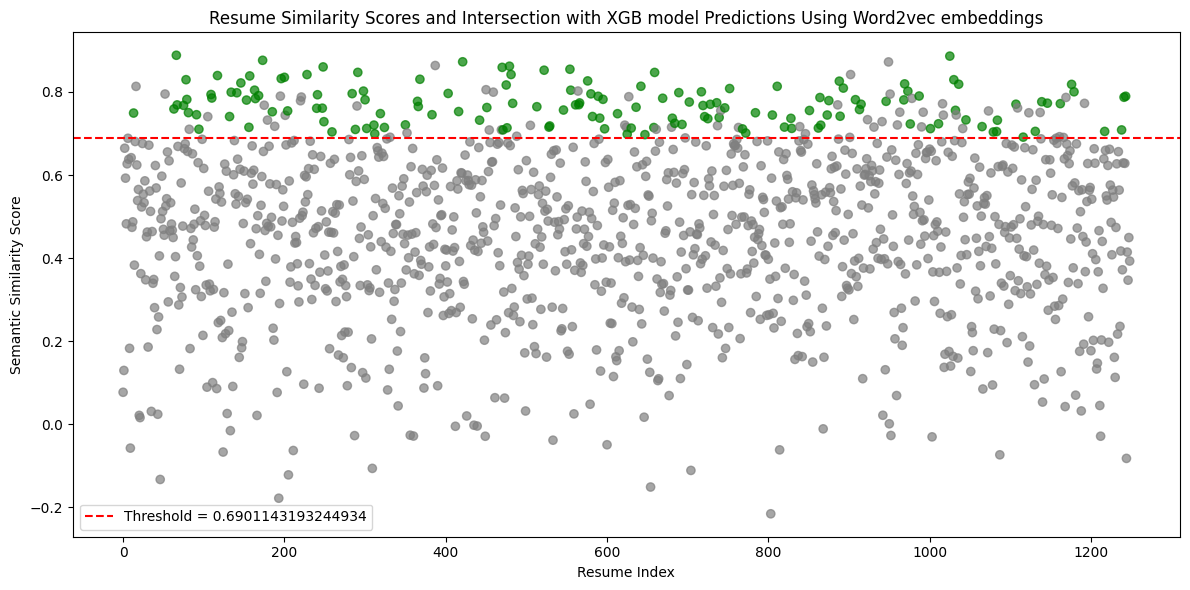

In [25]:

def compute_similarity_scores(resume_embed, jd_embed):
    similarities = cosine_similarity(resume_embed.reshape(1, -1), jd_embed.reshape(1, -1))
    return similarities[0, 0]  # each resume vs its own JD



similarity_scores = [
    compute_similarity_scores(X_resume_test[i], X_job_test[i])
    for i in range(X_resume_test.shape[0])
]


mean_similarity = np.mean(similarity_scores)
std_dev_similarity = np.std(similarity_scores)
threshold = mean_similarity + 1 * std_dev_similarity

#xgb_labels = xgb_predictions.map(inverse_label_mapping)
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
xgb_labels = [inverse_label_mapping[pred] for pred in xgb_predictions]


intersection_indices = [
    i for i, (label, score) in enumerate(zip(xgb_labels, similarity_scores))
    if (label == 'Good Fit' or label == 'Potential Fit') and score >= threshold
]

# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(similarity_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(similarity_scores)), similarity_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with XGB model Predictions Using Word2vec embeddings')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
print(f"Total samples: {len(similarity_scores)}")
print(f"Green dots (intersection count): {len(intersection_indices)}")
print(f"Mean similarity: {mean_similarity:.4f}")
print(f"Std dev similarity: {std_dev_similarity:.4f}")
print(f"Threshold used: {threshold:.4f}")

Total samples: 1249
Green dots (intersection count): 151
Mean similarity: 0.4804
Std dev similarity: 0.2097
Threshold used: 0.6901
